In [11]:
from pyshtools import legendre as pleg
from scipy.special import sph_harm as sph
from scipy.integrate import simps
import astropy.io.fits as pf
from math import sqrt, pi
import healpy as hp
import numpy as np
import time
NSIDE = 32 
NPIX = hp.nside2npix(NSIDE)
Nmax = int(2*sqrt(hp.nside2npix(NSIDE)))
print(f"For NSIDE = {NSIDE}, numPix = {NPIX}, Nmax = int(2*sqrt(numPix)) = {Nmax}")
%matplotlib notebook

For NSIDE = 32, numPix = 12288, Nmax = int(2*sqrt(numPix)) = 221


In [12]:
def make_map(theta, phi, data, NSIDE):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    
    """
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(_numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(_numPix, False, dtype=np.bool)
    counts = np.ones(_numPix, dtype=np.int) # used for averaging pixel data
    thetaNew = np.zeros(_numPix)
    phiNew = np.zeros(_numPix)
    
    for i, k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[_index], phiNew[_index] = hp.pix2ang(NSIDE, _index)
        if not existance[_index]:
            e1map[_index] = 0
            counts[_index] = 0
            existance[_index] = True
        e1map[_index] += k
        counts[_index] += 1
    print(f"Making healPy maps -- Complete")
    return e1map/counts, existance, thetaNew, phiNew

def make_map2(theta, phi, data, NSIDE, dth, dph):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    
    """
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(_numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(_numPix, False, dtype=np.bool)
    thetaNew = np.zeros(_numPix)
    phiNew = np.zeros(_numPix)
    
    for i, k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[_index], phiNew[_index] = hp.pix2ang(NSIDE, _index)
        if not existance[_index]:
            e1map[_index] = 0
            existance[_index] = True
        e1map[_index] += k * np.sin(theta[i]) * dth * dph * _numPix / 4 / pi
    print(f"Making healPy maps -- Complete")
    return e1map, existance, thetaNew, phiNew

def make_map_vec(theta, phi, data, NSIDE):
    assert len(theta) == len(phi) == len(data)
    e1map = np.full(hp.nside2npix(NSIDE), hp.UNSEEN, dtype=np.float)
    existance = np.full(hp.nside2npix(NSIDE), False, dtype=np.bool)
    index = hp.ang2pix(NSIDE, theta, phi)
    thetaNew = np.zeros(12*NSIDE**2)
    phiNew = np.zeros(12*NSIDE**2)
    thetaNew[index], phiNew[index] = hp.pix2ang(NSIDE, index)
    values = np.fromiter((np.sum(data[index==i]) for i in np.unique(index)), float, count=len(np.unique(index)))
    e1map[np.unique(index)] = values
    existance[np.unique(index)] = True
    return e1map, existance, thetaNew, phiNew

In [13]:
def restructure(ellArr, emmArr, lmax, coefs):
    """
    Restructures the alms into the format compatible with pleg
    
    i.e. newCoefs[0] corresponds to ell = 0, emm = 0
         newCoefs[1] corresponds to ell = 1, emm = 0
         newCoefs[2] corresponds to ell = 1, emm = 1
         newCoefs[3] corresponds to ell = 2, emm = 0
         newCoefs[4] corresponds to ell = 2, emm = 1 
         newCoefs[5] corresponds to ell = 2, emm = 2
         ..... and so on
    
    ===========================================================
    Inputs: (ellArr, emmArr, lmax, coefs)
    -----------------------------------------------------------
    ellArr  - array with ell corresponding to alms
    emmArr  - array with m corresponding to alms
    lmax    - maximum value of ell
    coefs   - alms
    ===========================================================
    Outputs: (newCoefs)
    -----------------------------------------------------------
    newCoefs - new alms in the format compatible with pleg
    ===========================================================
    
    """
    count = 0
    _maxind = int( (lmax + 1) * (lmax + 2) / 2 )
    newCoefs = np.zeros(_maxind, dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs

In [33]:
def gen_leg(lmax, theta):
    cost = np.cos(theta)
    sint = np.sin(theta)
    maxIndex = int( (lmax+1)*(lmax+2)/2 )
    leg = np.zeros( ( maxIndex, theta.size ) )
    leg_d1 = np.zeros( ( maxIndex, theta.size ) )
    dp_leg = np.zeros( (maxIndex, theta.size), dtype=complex)

    count = 0
    for z in cost:
        leg[:, count], leg_d1[:, count] = pleg.PlmBar_d1(lmax, z, 1, 1)
        count += 1
    dt_leg = leg_d1 * (-sint).reshape(1, sint.shape[0])
    
    ellArr = np.zeros(maxIndex)
    emmArr = np.zeros(maxIndex)
    countm, countl = 0, 0
    for i in range(maxIndex):
        ellArr[i] = countl
        emmArr[i] = countm
        if countm==countl:
            countl += 1
            countm = 0
        else:
            countm += 1
    norm = np.sqrt( ellArr * (ellArr + 1) )
    norm[norm<1] = 1.0
    
    legtemp = leg.copy()
    dp_leg = 1j * emmArr.reshape(maxIndex, 1) * legtemp / sint.reshape(1, sint.shape[0])
    dt_leg /= norm.reshape(maxIndex, 1)
    dp_leg /= norm.reshape(maxIndex, 1)
    return leg/sqrt(2)/sqrt(2*pi), dt_leg/sqrt(2)/sqrt(2*pi), dp_leg/sqrt(2)/sqrt(2*pi)

In [34]:
def minus1pow(m):
    if abs(m)%2==0:
        return 1
    else:
        return -1

# parameters for the synthetic map
lmaxSynth = 8 # maximum ell for the radial map
maxNum = int((lmaxSynth+1)*(lmaxSynth+2)/2)
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

theta = np.linspace(0, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi + 1e-4, pi - 1e-4, Nmax).reshape(1, Nmax)
dth = theta[1, 0] - theta[0, 0]
dph = phi[0, 1] - phi[0, 0]
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

# parameters for the synthetic map
lmaxSynth = 8 # maximum ell for the radial map
maxNum = int( (lmaxSynth+1)*(lmaxSynth+2)/2 )
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

theta = np.linspace(1e-4, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi + 1e-4, pi - 1e-4, Nmax).reshape(1, Nmax)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        if ell==0 and emm==0:
            almSynth[count] = ell*(np.random.rand() - 0.5)
            ellSynth[count] = ell
            data = almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
        else:
            almSynth[count] = ell*(np.random.rand() - 0.5)
            ellSynth[count] = ell
            data += almSynth[count]*sph(emm, ell, phi, theta)
            count += 1

lr = np.cos(THETA)
lt = -np.sin(THETA)

map_r = data# * lr
map_p = data * lt / sqrt(2)
map_m = data * lt / sqrt(2)

leg, dt_leg, dp_leg = gen_leg(lmaxSynth, theta.flatten())
legP = ( dt_leg - 1j*dp_leg )/sqrt(2)
legM = ( dt_leg + 1j*dp_leg )/sqrt(2)

almR = np.zeros(maxNum, dtype=complex)
almP = np.zeros(maxNum, dtype=complex)
almM = np.zeros(maxNum, dtype=complex)

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        cosmp = np.cos(emm*phi)
        sinmp = np.sin(emm*phi)
        eimp = (cosmp - 1j*sinmp).reshape(1, Nmax) * minus1pow(emm)
        almR[count] = simps( simps( map_r * ( leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        almP[count] = simps( simps( map_p * ( dt_leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        almM[count] = simps( simps( map_m * ( dp_leg[count, :].reshape(Nmax, 1) * eimp ) * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())
        count += 1
print("Explicit computation of alms -- Complete")

Explicit computation of alms -- Complete


/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete


<IPython.core.display.Javascript object>


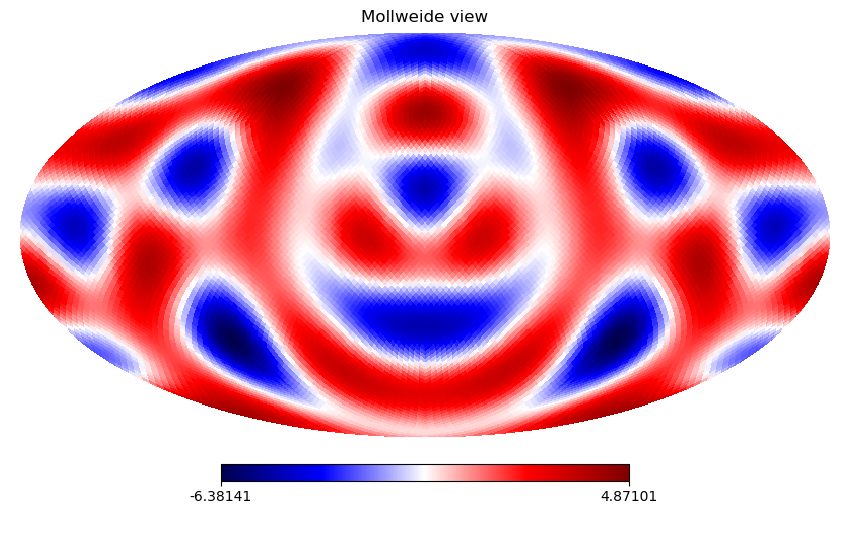

<IPython.core.display.Javascript object>


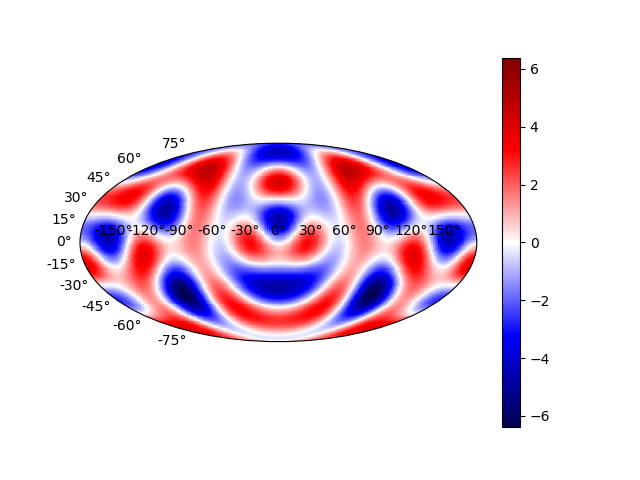

orig map: max = 4.8885531676084435, min = -6.390348739680346
hp map: max = 4.871014568340936, min = -6.381408788300984


In [35]:
map0, mask0, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), map_r.flatten(), NSIDE)
mapp, maskp, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), map_p.flatten(), NSIDE)
mapm, maskm, _th, _ph = make_map(THETA.flatten(), PHI.flatten(), map_m.flatten(), NSIDE)
#map0, mask0, _th, _ph = make_map2(THETA.flatten(), PHI.flatten(), map_r.flatten(), NSIDE, dth, dph)
#mapp, maskp, _th, _ph = make_map2(THETA.flatten(), PHI.flatten(), map_p.flatten(), NSIDE, dth, dph)
#mapm, maskm, _th, _ph = make_map2(THETA.flatten(), PHI.flatten(), map_m.flatten(), NSIDE, dth, dph)
hp.mollview(map0, cmap='seismic')



fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

lon = phi.flatten().copy()
lat = theta.flatten().copy() - pi/2
Lon,Lat = np.meshgrid(lon, -lat)

_max1 = map_r.real.max(); _min1 = map_r.real.min(); _vmax = max(abs(_max1), abs(_min1))
im = ax.pcolormesh(Lon,Lat, map_r.real, cmap='seismic', vmax=_vmax, vmin=-_vmax)
plt.colorbar(im)
plt.show()
print(f"orig map: max = {map_r.real.max()}, min = {map_r.real.min()}")
print(f"hp map: max = {map0.real.max()}, min = {map0.real.min()}")
map_trans = [mapp, mapm]
map0[~mask0] = hp.UNSEEN
map_trans[0][~maskp] = 0.0#hp.UNSEEN
map_trans[1][~maskp] = 0.0#hp.UNSEEN
alm_rRot = hp.map2alm(map0)
alm_pm = hp.map2alm_spin(map_trans, 1)
alm_v, alm_w = alm_pm[0], alm_pm[1]
alm_p = alm_pm[0]
alm_m = alm_pm[1]
alm_vRot = -alm_p
alm_wRot = -1j*alm_m

# getting ellmax, ellArr and emmArr
ellmax = hp.sphtfunc.Alm.getlmax(len(alm_rRot))
ellArr, emmArr = hp.sphtfunc.Alm.getlm(ellmax)

almR_hp = restructure(ellArr, emmArr, lmaxSynth, alm_rRot)
almP_hp = restructure(ellArr, emmArr, lmaxSynth, alm_p)
almM_hp = restructure(ellArr, emmArr, lmaxSynth, alm_m)


<IPython.core.display.Javascript object>


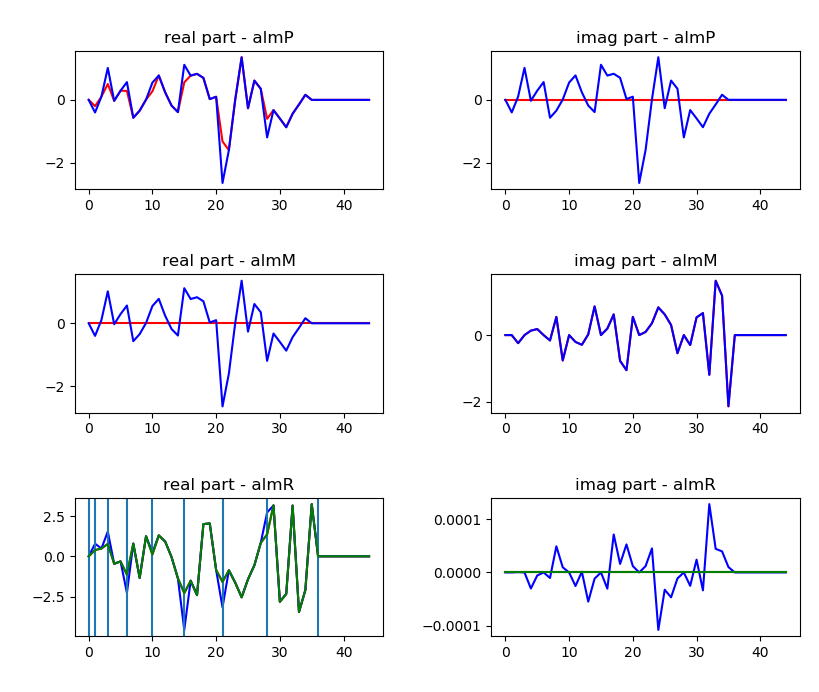

In [38]:
plt.figure()

plt.subplot(321)
plt.plot(almP.real, 'r')
plt.plot(almP_hp.real*2, 'b')
plt.title('real part - almP')

plt.subplot(322)
plt.plot(almP.imag, 'r')
plt.plot(almP_hp.real*2, 'b')
plt.title('imag part - almP')

plt.subplot(323)
plt.plot(almM.real, 'r')
plt.plot(almM_hp.real*2, 'b')
plt.title('real part - almM')

plt.subplot(324)
plt.plot(almM.imag, 'r')
plt.plot(almM_hp.imag*2, 'b')
plt.title('imag part - almM')

plt.subplot(325)
plt.plot(almR.real, 'r')
plt.plot(almR_hp.real*2, 'b')
plt.axvline(x=0)
plt.axvline(x=1)
plt.axvline(x=3)
plt.axvline(x=6)
plt.axvline(x=10)
plt.axvline(x=15)
plt.axvline(x=21)
plt.axvline(x=28)
plt.axvline(x=36)
plt.plot(almSynth, 'g')
plt.title('real part - almR')

plt.subplot(326)
plt.plot(almR.imag, 'r')
plt.plot(almR_hp.imag, 'b')
plt.plot(almSynth*0, 'g')
plt.title('imag part - almR')

plt.tight_layout()
plt.show()

In [78]:
map_r

array([[-2.8393677 +1.65555360e-07j, -2.83937046+9.55419754e-05j,
        -2.83937871+1.90601039e-04j, ..., -2.83937871-1.90601039e-04j,
        -2.83937046-9.55419754e-05j, -2.8393677 -1.65555360e-07j],
       [-2.33366045+4.76086300e-05j, -2.33445261+2.74750105e-02j,
        -2.33682102+5.48116075e-02j, ..., -2.33682102-5.48116075e-02j,
        -2.33445261-2.74750105e-02j, -2.33366045-4.76086300e-05j],
       [-1.78028675+9.37258521e-05j, -1.78184426+5.40893924e-02j,
        -1.78650084+1.07906691e-01j, ..., -1.78650084-1.07906691e-01j,
        -1.78184426-5.40893924e-02j, -1.78028675-9.37258521e-05j],
       ...,
       [-2.55774307+5.24385810e-06j, -2.55778794+3.02858652e-03j,
        -2.55792282+6.05593898e-03j, ..., -2.55792282-6.05593898e-03j,
        -2.55778794-3.02858652e-03j, -2.55774307-5.24385810e-06j],
       [-2.73370312+3.27035897e-06j, -2.73374655+1.88796653e-03j,
        -2.73387662+3.77022489e-03j, ..., -2.73387662-3.77022489e-03j,
        -2.73374655-1.88796653e-03j

<IPython.core.display.Javascript object>


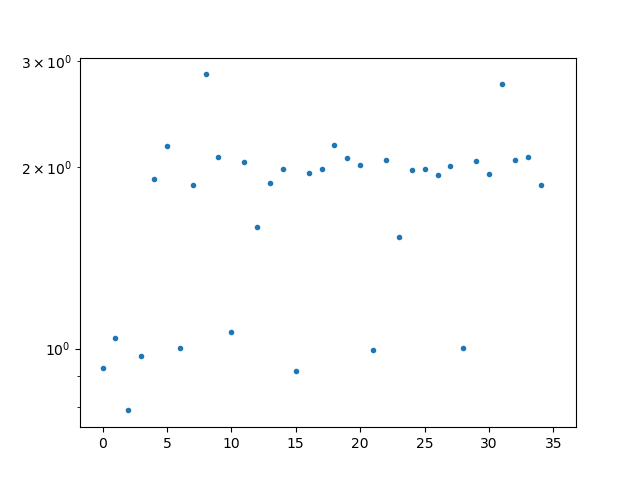

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
plt.figure()

plt.semilogy(almR.real/almR_hp.real, '.')

plt.show()

In [71]:
simps( simps( leg[0, :].reshape(Nmax, 1)* leg[2, :].reshape(Nmax, 1) * np.sin(theta) * np.ones((Nmax, Nmax)), axis=0, x=theta.flatten()), x=phi.flatten())

0.9618841963927703

<IPython.core.display.Javascript object>


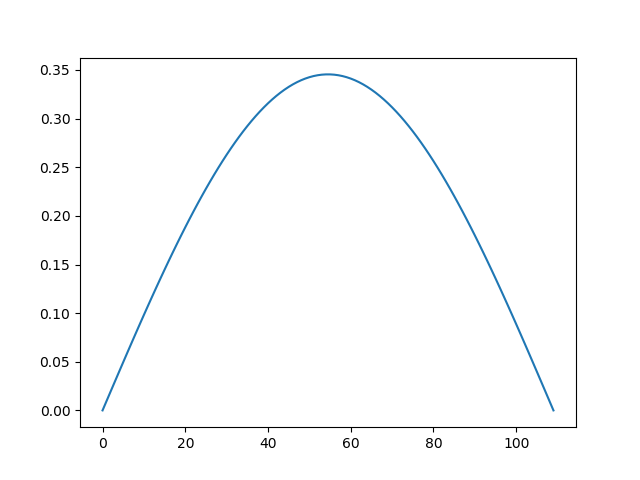

In [73]:
plt.figure()
plt.plot(leg[2, :])# * np.sin(theta).flatten())
plt.show()

In [135]:
map_r

array([[0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       ...,
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j]])

In [127]:
simps( simps( sph(-1, 1, phi, theta) * sph(-1, 1, phi, theta).conjugate() * np.sin(theta), axis=0, x=theta.flatten()), x=phi.flatten())

(0.9999681669323566+0j)